**Проект для «Викишоп» с BERT**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Открытие и изучение датасета

Импорты

In [1]:
%pip install transformers
%pip install catboost
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.5 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
     |████████████████████████████████| 86 kB 1.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tqdm import notebook
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle 
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_comments.csv')

In [5]:
def info_df(df):  
    display(df.head()) #первые пять строк 
    display(df.info()) #общую информацию 
    display(df.isna().sum()) #пропуски 
    display(df.duplicated().sum()) #дубликаты 
                     
display(info_df(df))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

text     0
toxic    0
dtype: int64

0

None

Посмотрим на баланс классов

0    0.898321
1    0.101679
Name: toxic, dtype: float64


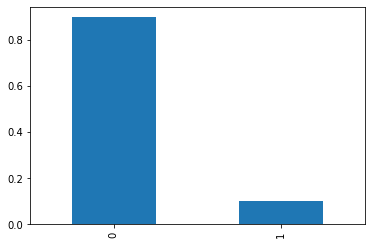

In [6]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Действительно есть дисбаланс, его устраним позже.

# 2. Предобработка текста и подготовка к обучению

Начнеём предобработку текста: очитим текст, приведём к нижнему регистру и выполним токенизацию и лемматизацию.

In [7]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

df['text'] = df['text'].apply(clear_text)

df['text'] = df['text'].str.lower()

df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Проверим на дубликаты.

In [8]:
df.duplicated().sum()

1293

Избавимся от дубликатов

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Датасет достаточно большой, поэтому выберем 3000 случайных строк.

In [10]:
df = df.sample(3000).reset_index(drop=True)

In [12]:
def make_embeddings(features):
  model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

  # Загрузка предобученной модели/токенизатора 
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  tokenized= features.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
      max_len = len(i)

  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  batch_size = 100

  embeddings = []
  for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
      batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  final_features = np.concatenate(embeddings)
  final_features = pd.DataFrame(final_features)
  return final_features

In [13]:
features = make_embeddings(df['text'])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
target = df['toxic'].reset_index(drop=True)

Разделение на выборки

In [15]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
features, target, test_size=0.4, stratify=target, random_state=12345) # разделили выборки в пропорции 4 к 10

features_test, features_valid, target_test, target_valid = train_test_split(
features_valid_test, target_valid_test, test_size=0.5, stratify=target_valid_test, random_state=12345) 

In [16]:
#посмотрим на размер новых даатасетов
def info_df(features_train, target_train, features_test, features_valid, target_test, target_valid): #на вход функция принимает все датасеты сразу
    df_all = [features_train, target_train, features_test, features_valid, target_test, target_valid]
    for i in df_all:
        print(i.shape)
                    
display(info_df(features_train, target_train, features_test, features_valid, target_test, target_valid))

(1800, 768)
(1800,)
(600, 768)
(600, 768)
(600,)
(600,)


None

Устранение дисбаланса методом upsample

In [17]:
features_zeros = features_train[target_train == 0]  

features_ones = features_train[target_train == 1]  

target_zeros = target_train[target_train == 0]  

target_ones = target_train[target_train == 1]  

display(features_zeros.shape) 
display(features_ones.shape) 
display(target_zeros.shape) 
display(target_ones.shape) 

(1611, 768)

(189, 768)

(1611,)

(189,)

In [18]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 

    target_zeros = target[target == 0] 
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) 

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345) 
    return features_upsampled, target_upsampled  

features_upsampled, target_upsampled = upsample(features_train, target_train, 10) 


display(features_upsampled.shape) 
display(target_upsampled.shape)

(3501, 768)

(3501,)

# 3. Обучение моделей

Логистическая регрессия

In [19]:
%%time

best_model = None
best_result = 0
best_с = 0
for reg in np.linspace(0.0001, 100, 20):
    model = LogisticRegression(random_state=12345, solver='liblinear', C=reg)
    model.fit(features_upsampled, target_upsampled) # обучаем модель на обучающей выборке
    predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    result = f1_score(target_valid, predictions) # посчитаем качество модели
    print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_с = reg
        
display('Наилучшее качество модели {:.3f} при регуляризации {}'.format(best_result, best_с))

0.3037974683544304
0.6428571428571429
0.6382978723404256
0.6285714285714286
0.6285714285714286
0.6285714285714286
0.6285714285714286
0.6285714285714286
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6376811594202899
0.6423357664233577
0.6423357664233577


'Наилучшее качество модели 0.643 при регуляризации 5.263252631578947'

CPU times: user 26.3 s, sys: 1.92 s, total: 28.2 s
Wall time: 26 s


Случайный лес

In [20]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 101, 10):
    for depth in range (1, 9):
        for spl in (2, 7):
            model = RandomForestClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     max_depth=depth, min_samples_split = spl) # инициализируем модель
            model.fit(features_upsampled, target_upsampled) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = spl

display("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth,
     "Минимальное количество примеров для разделения", best_split)

0.45614035087719296
0.45614035087719296
0.5310734463276836
0.5310734463276836
0.5568181818181819
0.5568181818181819
0.5503355704697986
0.5503355704697986
0.6259541984732825
0.6259541984732825
0.6290322580645161
0.6229508196721311
0.6034482758620691
0.6260869565217392
0.6608695652173913
0.6964285714285715
0.4977375565610859
0.4977375565610859
0.5536723163841808
0.5536723163841808
0.6012269938650306
0.6012269938650306
0.6027397260273972
0.6027397260273972
0.6821705426356589
0.6875
0.6890756302521008
0.6890756302521008
0.6495726495726495
0.6440677966101694
0.6902654867256637
0.6956521739130435
0.48181818181818176
0.48181818181818176
0.5494505494505495
0.5494505494505495
0.6296296296296297
0.6296296296296297
0.6027397260273972
0.6027397260273972
0.6614173228346457
0.6771653543307087
0.6666666666666666
0.6890756302521008
0.6371681415929202
0.6837606837606837
0.6608695652173913
0.6785714285714285
0.49090909090909085
0.49090909090909085
0.5683060109289617
0.5683060109289617
0.5988023952095809

'F1 наилучшей модели на валидационной выборке:'

0.75

'Количество деревьев:'

100

'Максимальная глубина:'

8

'Минимальное количество примеров для разделения'

2

CPU times: user 2min 58s, sys: 258 ms, total: 2min 59s
Wall time: 2min 58s


LGBM

In [21]:
%%time

best_model = None
best_result = 0
best_est = 0
best_leaves = 0
best_rate = 0
for est in [50, 100, 500]:
    for leave in [21, 31, 41, 51]:
        for rate in [0.01, .04, 0.06, 0.3]:
            model = LGBMClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     num_leaves=leave, learning_rate = rate) # инициализируем модель
            model.fit(features_upsampled, target_upsampled) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_leaves = leave
                best_rate = rate

display("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Скорость обучения:", best_rate,
     "Количество листьев", best_leaves)

0.6250000000000001
0.6666666666666666
0.7008547008547008
0.6605504587155963
0.6187050359712231
0.6610169491525425
0.672566371681416
0.6981132075471699
0.6307692307692307
0.6434782608695652
0.6909090909090909
0.6601941747572816
0.6106870229007633
0.6491228070175439
0.6727272727272727
0.6990291262135921
0.62015503875969
0.6782608695652174
0.7090909090909091
0.6846846846846846
0.6229508196721311
0.6902654867256637
0.6909090909090909
0.679245283018868
0.6440677966101694
0.6788990825688073
0.6857142857142857
0.6666666666666667
0.6333333333333333
0.6964285714285715
0.6981132075471699
0.7058823529411765
0.7079646017699115
0.6981132075471699
0.6981132075471699
0.7027027027027026
0.6972477064220184
0.6796116504854369
0.6796116504854369
0.679245283018868
0.6851851851851852
0.6666666666666666
0.673076923076923
0.6666666666666667
0.6666666666666666
0.673076923076923
0.6796116504854369
0.7058823529411765


'F1 наилучшей модели на валидационной выборке:'

0.7090909090909091

'Количество деревьев:'

100

'Скорость обучения:'

0.06

'Количество листьев'

21

CPU times: user 21min 35s, sys: 2.14 s, total: 21min 37s
Wall time: 21min 41s


CatBoost

In [22]:
%%time

best_model = None
best_result = 0
best_iter = 0
best_rate = 0
for iter in [150, 500]:
  for rate in [0.01, .04, 0.06, 0.3, 0.5]:
    model = CatBoostClassifier(random_state=12345, 
                                     iterations=iter, learning_rate = rate) # инициализируем модель
    model.fit(features_upsampled, target_upsampled) # обучим модель на тренировочной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
    print(result)
    if result > best_result:
      best_model = model
      best_result = result
      best_iter = iter
      best_rate = rate

display("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество иттераций:", best_iter, "Скорость обучения:", best_rate)

0:	learn: 0.6812353	total: 293ms	remaining: 43.6s
1:	learn: 0.6684888	total: 483ms	remaining: 35.7s
2:	learn: 0.6582289	total: 666ms	remaining: 32.7s
3:	learn: 0.6507359	total: 846ms	remaining: 30.9s
4:	learn: 0.6414766	total: 1.02s	remaining: 29.7s
5:	learn: 0.6336186	total: 1.19s	remaining: 28.6s
6:	learn: 0.6253337	total: 1.39s	remaining: 28.4s
7:	learn: 0.6142400	total: 1.57s	remaining: 27.9s
8:	learn: 0.6058668	total: 1.77s	remaining: 27.8s
9:	learn: 0.5977613	total: 1.97s	remaining: 27.6s
10:	learn: 0.5904850	total: 2.16s	remaining: 27.3s
11:	learn: 0.5826673	total: 2.37s	remaining: 27.2s
12:	learn: 0.5750272	total: 2.56s	remaining: 27s
13:	learn: 0.5663141	total: 2.76s	remaining: 26.8s
14:	learn: 0.5586584	total: 2.95s	remaining: 26.6s
15:	learn: 0.5509643	total: 3.13s	remaining: 26.3s
16:	learn: 0.5439125	total: 3.31s	remaining: 25.9s
17:	learn: 0.5368815	total: 3.51s	remaining: 25.7s
18:	learn: 0.5305359	total: 3.68s	remaining: 25.4s
19:	learn: 0.5230710	total: 3.86s	remaining

'F1 наилучшей модели на валидационной выборке:'

0.706896551724138

'Количество иттераций:'

500

'Скорость обучения:'

0.04

CPU times: user 18min 56s, sys: 6.43 s, total: 19min 2s
Wall time: 10min 2s


# Анализ обученных моделей

In [26]:
# создадим таблицу для хранения результатов
d = {'model': [], 'F_1':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,F_1,fit_time,predict_time


In [24]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model):
    f_1, fit_time, pred_time = ml(model)
    results.loc[len(results)] = [model_name, f_1, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [27]:
# cоздадим функцию для расчета необходимых параметров
def ml (model):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    f_1 = f1_score(target_test, predictions)
    
    return f_1, fit_time, pred_time

Логистическая регрессия

In [28]:
# логистическая регрессия
lr = LogisticRegression(random_state=12345, solver='liblinear', C=5.263252631578947)
model_res('LogisticRegression', lr)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.683333,0.32545,0.007058


Случайный лес

In [29]:
# случайный лес
rf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=12345, min_samples_split=2)
model_res('RandomForestClassifier', rf)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.683333,0.32545,0.007058
1,RandomForestClassifier,0.405063,2.51402,0.022396


LGBM

In [30]:
# Light GBM
lgbm = LGBMClassifier(learning_rate=0.06, n_estimators=100, num_leaves=21, random_state=12345)
model_res('LGBMClassifier', lgbm)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.683333,0.325450,0.007058
1,RandomForestClassifier,0.405063,2.514020,0.022396
2,LGBMClassifier,0.597938,10.081851,0.013188


CatBoost

In [31]:
# CatBoost
cb = CatBoostClassifier(learning_rate=0.04, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostClassifier', cb)
display(results)

0:	learn: 0.6490168	total: 223ms	remaining: 1m 51s
1:	learn: 0.6031060	total: 402ms	remaining: 1m 40s
2:	learn: 0.5610586	total: 578ms	remaining: 1m 35s
3:	learn: 0.5312176	total: 754ms	remaining: 1m 33s
4:	learn: 0.4963425	total: 940ms	remaining: 1m 33s
5:	learn: 0.4642340	total: 1.11s	remaining: 1m 31s
6:	learn: 0.4370983	total: 1.29s	remaining: 1m 30s
7:	learn: 0.4111867	total: 1.47s	remaining: 1m 30s
8:	learn: 0.3846790	total: 1.65s	remaining: 1m 29s
9:	learn: 0.3622974	total: 1.83s	remaining: 1m 29s
10:	learn: 0.3422265	total: 2.02s	remaining: 1m 29s
11:	learn: 0.3278706	total: 2.19s	remaining: 1m 29s
12:	learn: 0.3107471	total: 2.37s	remaining: 1m 28s
13:	learn: 0.2968671	total: 2.54s	remaining: 1m 28s
14:	learn: 0.2853424	total: 2.71s	remaining: 1m 27s
15:	learn: 0.2736855	total: 2.89s	remaining: 1m 27s
16:	learn: 0.2642062	total: 3.08s	remaining: 1m 27s
17:	learn: 0.2547403	total: 3.26s	remaining: 1m 27s
18:	learn: 0.2449192	total: 3.44s	remaining: 1m 27s
19:	learn: 0.2363238	t

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.683333,0.325450,0.007058
1,RandomForestClassifier,0.405063,2.514020,0.022396
2,LGBMClassifier,0.597938,10.081851,0.013188
3,CatBoostClassifier,0.602151,89.500726,0.042707


Результаты

In [32]:
results

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.683333,0.325450,0.007058
1,RandomForestClassifier,0.405063,2.514020,0.022396
2,LGBMClassifier,0.597938,10.081851,0.013188
3,CatBoostClassifier,0.602151,89.500726,0.042707


**Вывод**

Самый лучший результат у Логистической регрессиипо метрике и по времени. Значит её и возьмём в работу.